### Load Libraries

In [2]:
import colorcet as cc
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

### Load Dataset

In [3]:
reduced_data = pd.read_csv("reduced_data.csv", delimiter=";")

## Outlier Detection and Marking

### Outlier boxplots

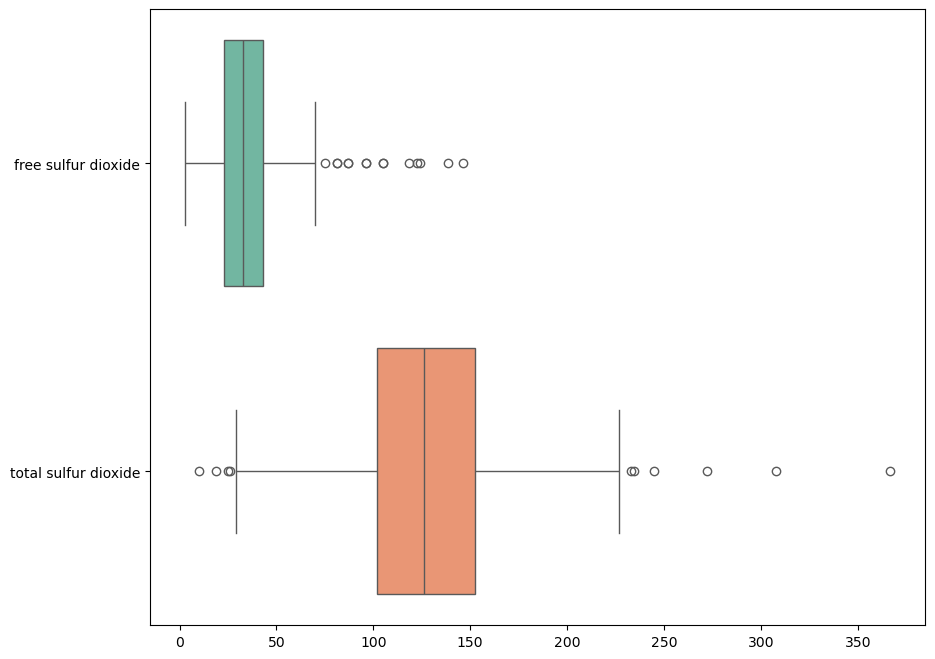

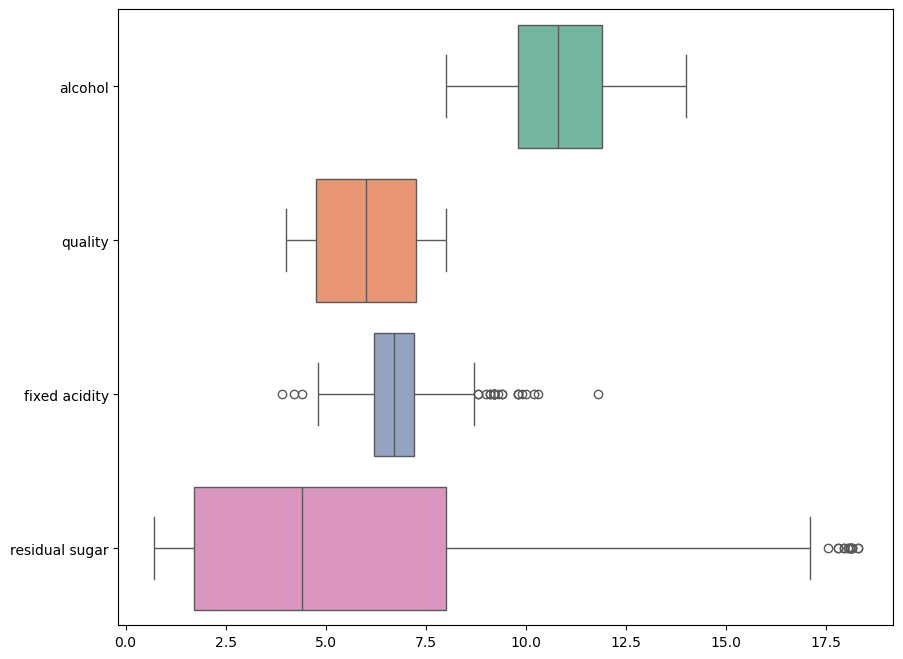

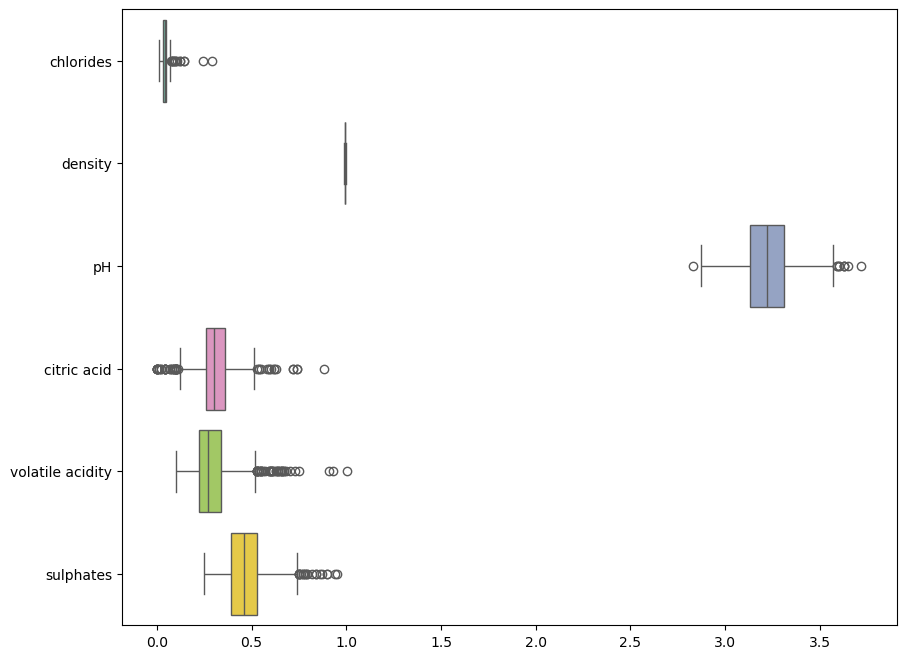

In [4]:
def plot_boxplot(df, columns):
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df[columns], orient="h", palette="Set2")
    plt.show()

# copy of reduced_data
boxplot_data = reduced_data.copy()

# Boxplots
column_list = list(boxplot_data.columns)
chosen_columns = ['free sulfur dioxide', 'total sulfur dioxide'] 
if not chosen_columns:
    chosen_columns = list(boxplot_data.columns)
    plot_boxplot(boxplot_data, chosen_columns)
else:
    plot_boxplot(boxplot_data, chosen_columns)
    chosen_columns2 = ['alcohol', 'quality', 'fixed acidity', 'residual sugar']
    plot_boxplot(boxplot_data, chosen_columns2)
    column_list = list(set(column_list) - set(chosen_columns) - set(chosen_columns2))
    plot_boxplot(boxplot_data, column_list)

#### Outlier marking and statistics

In [5]:
def remove_outliers(df, columns):
    outlier_counts = {} # Dictionary to store outlier counts
    outlier_indices = pd.Index([]) # Empty index to store outliers
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        is_outlier = ~((df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR)))
        outlier_counts[column] = is_outlier.sum()  # Count outliers for the column
        outlier_indices = outlier_indices.union(df[is_outlier].index)

    # Remove outliers at once
    df_clean = df.drop(index=outlier_indices)
    return df_clean, outlier_counts, outlier_indices

clean_data = reduced_data.copy()

clean_data, outlier_counts, outlier_indices = remove_outliers(clean_data, list(clean_data.columns))

outlier_indices = reduced_data.index.difference(clean_data.index)
reduced_data['outlier'] = 0
reduced_data.loc[outlier_indices, 'outlier'] = 1

print(f"{'Column':<30} {'Count':<10} {'Percentage'}")
for column in clean_data.columns:
    count = outlier_counts.get(column, 0)
    percentage = (count / len(reduced_data)) * 100
    print(f"{column:<30} {count:<10} {percentage:.2f}%")

outlier_distribution = reduced_data['outlier'].value_counts()

display(outlier_distribution)

Column                         Count      Percentage
fixed acidity                  26         3.61%
volatile acidity               42         5.83%
citric acid                    48         6.67%
residual sugar                 15         2.08%
chlorides                      15         2.08%
free sulfur dioxide            14         1.94%
total sulfur dioxide           10         1.39%
density                        0          0.00%
pH                             10         1.39%
sulphates                      20         2.78%
alcohol                        0          0.00%
quality                        0          0.00%


outlier
0    559
1    161
Name: count, dtype: int64

### Outlier column check

In [6]:
reduced_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,outlier
0,8.3,0.27,0.45,1.3,0.048,8.0,72.0,0.99440,3.08,0.61,10.3,4,0
1,8.2,0.26,0.44,1.3,0.046,7.0,69.0,0.99440,3.14,0.62,10.2,4,0
2,9.2,0.19,0.42,2.0,0.047,16.0,104.0,0.99517,3.09,0.66,10.0,4,1
3,9.4,0.29,0.55,2.2,0.050,17.0,119.0,0.99620,3.12,0.69,10.3,4,1
4,8.4,0.19,0.42,1.6,0.047,9.0,101.0,0.99400,3.06,0.65,11.1,4,0


## Feature selection

### Fit features to PCA to find optimal number of features to keep

array([0.47265657, 0.68005074, 0.75986057, 0.81910256, 0.86578193,
       0.90543456, 0.94193702, 0.9707423 , 0.98347498, 0.99292232,
       0.9985016 , 1.        ])

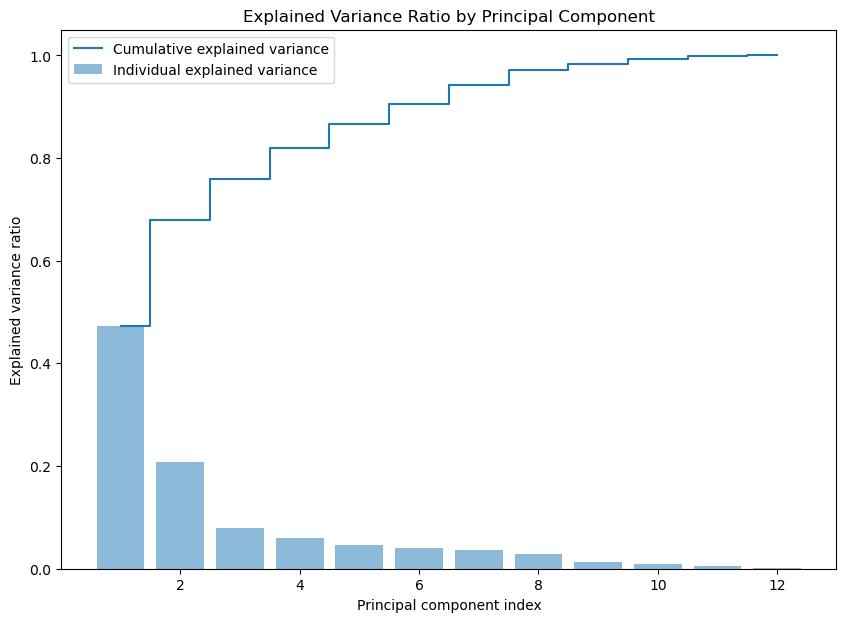

In [7]:
##### Include outliers in results or not
include_outliers = True

feature_selection_data = reduced_data.copy()

wine_features = feature_selection_data.copy()

if include_outliers:
        wine_features = wine_features.drop(columns=['outlier'])
else:
        feature_selection_data = feature_selection_data[feature_selection_data['outlier'] == 0]
        wine_features = wine_features[wine_features['outlier'] == 0].drop(columns=['outlier'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(wine_features)
scaled_wine_data = pd.DataFrame(scaled_features, columns=wine_features.columns)

pca = PCA()
pca.fit(scaled_wine_data)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
display(explained_variance_ratio.cumsum())

# Plot the explained variance ratio for each principal component
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', 
        label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

#### Fit and Transform selected number of components using PCA

In [44]:
# Select the number of components to keep based on the explained variance ratio
if include_outliers:
    n_components = 6
else:
    n_components = 7
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_wine_data)

#### Calculating and Presenting PCA Loadings

In [45]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=scaled_wine_data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
fixed acidity,0.026159,0.009624,-0.057120,0.053544,-0.032444,-0.007096
volatile acidity,0.017632,-0.036056,-0.028632,0.003015,0.067056,0.014420
citric acid,-0.011398,0.023876,-0.028434,0.050972,-0.012231,-0.032606
residual sugar,0.121506,0.212396,-0.035914,-0.020386,0.064570,-0.013748
chlorides,0.027195,0.006271,0.005713,0.008204,-0.002454,0.001637
free sulfur dioxide,0.003559,0.050495,0.030368,0.011669,-0.003898,0.099186
total sulfur dioxide,0.039727,0.045400,0.029946,0.020210,0.001785,0.065489
density,0.167542,0.118079,0.020828,0.012863,-0.014595,-0.022722
pH,-0.017339,-0.014122,0.136528,-0.046480,0.035349,-0.031467
sulphates,-0.015431,-0.000561,0.072119,0.131238,0.033869,-0.015573


### PCA Reduction to two components

In [46]:
org_pca = PCA(n_components=2)
org_pca_result = org_pca.fit_transform(scaled_wine_data)

### Clustering using PCA

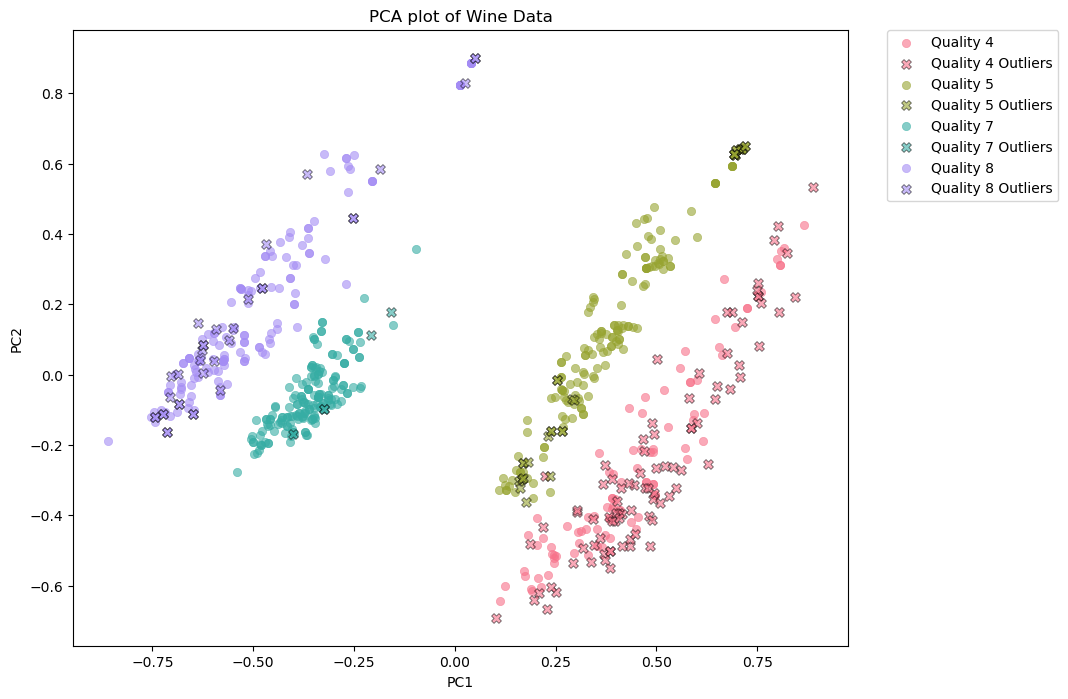

In [47]:
org_pca_result_df = pd.DataFrame({
    'PC1': org_pca_result[:, 0],
    'PC2': org_pca_result[:, 1],
    'Quality': feature_selection_data['quality'],
    'Outlier': feature_selection_data['outlier']
})

# Create a color palette with a unique color for each quality level (might be modified later)
palette = sns.color_palette("husl", len(org_pca_result_df['Quality'].unique()))
color_mapping = dict(zip(sorted(org_pca_result_df['Quality'].unique()), palette))

plt.figure(figsize=(10, 8))

# Plot non-outliers
for quality in org_pca_result_df['Quality'].unique():
    subset = org_pca_result_df[(org_pca_result_df['Quality'] == quality) & (org_pca_result_df['Outlier'] == 0)]
    sns.scatterplot(
        x="PC1", y="PC2",
        color=color_mapping[quality],
        data=subset,
        label=f'Quality {quality}',
        alpha=0.6,
        edgecolor=None
    )

# Plot outliers
    if include_outliers:
        outlier_subset = org_pca_result_df[(org_pca_result_df['Quality'] == quality) & (org_pca_result_df['Outlier'] == 1)]
        sns.scatterplot(
            x="PC1", y="PC2",
            color=color_mapping[quality],
            data=outlier_subset,
            label=f'Quality {quality} Outliers',
            alpha=0.6,
            marker='X',
            s=50,
            edgecolor='black'
        )

plt.title('PCA plot of Wine Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### DBSCAN

#### K-distance graph to determine epsilon

epsilon: 0.10815320921139261


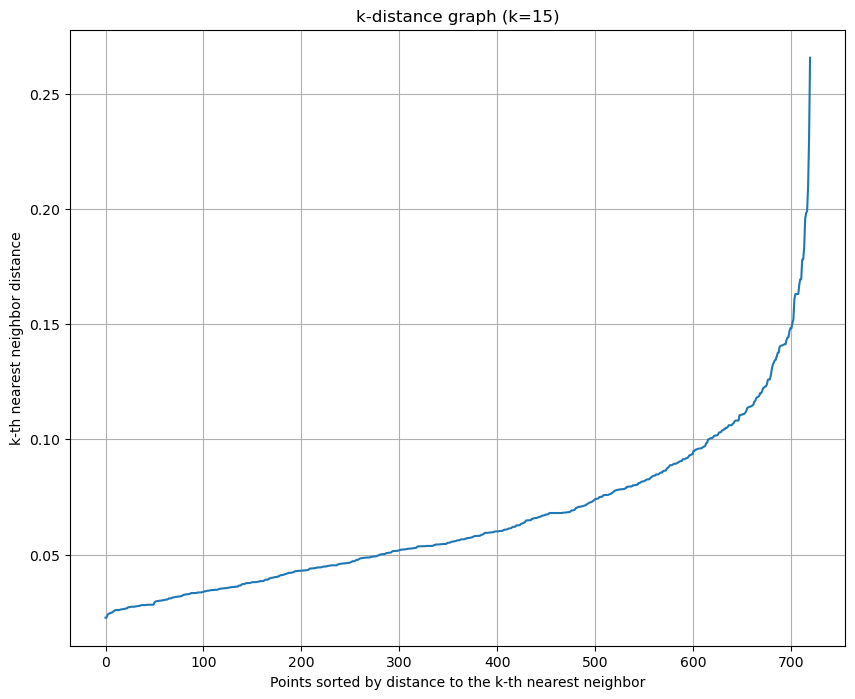

In [48]:
# Choose the 'k' for k-distance, often set to the min_samples value used in DBSCAN
k = 15

# Compute the nearest neighbors
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(org_pca_result)
distances, indices = nbrs.kneighbors(org_pca_result)

# Sort the distances
sorted_distances = np.sort(distances, axis=0)
sorted_distances = sorted_distances[:, k-1]

n_points = len(sorted_distances)
line = np.linspace(sorted_distances[0], sorted_distances[-1], n_points)
distance_from_line = np.abs(sorted_distances - line)
epsilon = sorted_distances[np.argmax(distance_from_line)]

print(f"epsilon: {epsilon}")
# Plot the k-distance graph
plt.figure(figsize=(10, 8))
plt.plot(sorted_distances)
plt.title(f'k-distance graph (k={k})')
plt.xlabel('Points sorted by distance to the k-th nearest neighbor')
plt.ylabel('k-th nearest neighbor distance')
plt.grid(True)
plt.show()


#### DBSCAN Clustering

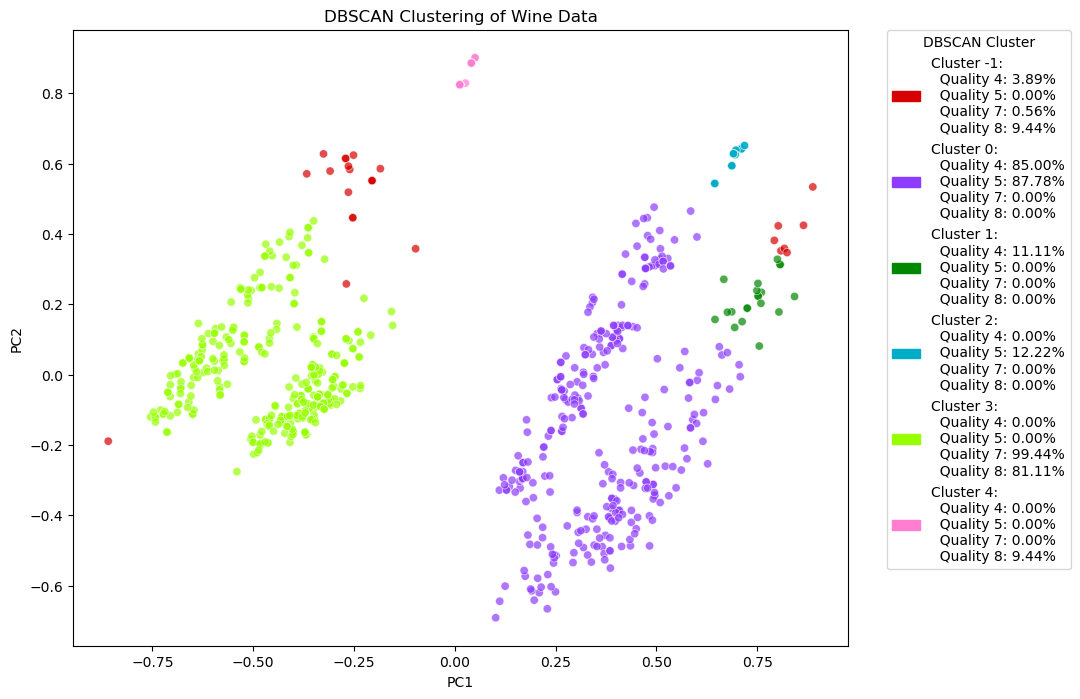

In [49]:
# Need to tune epsilon and min_samples
dbscan = DBSCAN(eps=epsilon, min_samples=k)

clusters = dbscan.fit_predict(org_pca_result)

#Noise is -1

org_dbscan_result_df=org_pca_result_df.copy()
org_dbscan_result_df['Cluster']=clusters

palette = sns.color_palette(cc.glasbey, n_colors=len(org_dbscan_result_df['Cluster'].unique()))

total_quality_counts = org_dbscan_result_df['Quality'].value_counts()
cluster_quality_counts = org_dbscan_result_df.groupby(['Cluster', 'Quality']).size()
quality_percentage_in_clusters = cluster_quality_counts.div(total_quality_counts, level='Quality') * 100

# Prepare legend information with the calculated percentages
legend_labels = []
for cluster in sorted(org_dbscan_result_df['Cluster'].unique()):
    labels = [f"Cluster {cluster}:"]
    for quality in sorted(org_dbscan_result_df['Quality'].unique()):
        percentage = quality_percentage_in_clusters.loc[(cluster, quality)] if (cluster, quality) in quality_percentage_in_clusters.index else 0
        if percentage > 0:
            labels.append(f"  Quality {quality}: {percentage:.2f}%")
        else:
            labels.append(f"  Quality {quality}: 0.00%")
    legend_labels.append('\n'.join(labels))

# Create custom legend objects for the data points
legend_objects = [mpatches.Patch(color=palette[i], label=label)
                  for i, label in enumerate(legend_labels)]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster",
    palette=palette,
    data=org_dbscan_result_df,
    legend="full",
    alpha=0.7
)

plt.legend(handles=legend_objects, title='DBSCAN Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('DBSCAN Clustering of Wine Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()